In [63]:
!pip install nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import nltk
import string

In [64]:
!pip install gensim

In [95]:
# using dataset sentiment140 (160k rows)
data = pd.read_csv('twitter dataset.csv', encoding='iso-8859-1')

In [96]:
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [97]:
data.columns = ['label', 'id', 'timestamp','no_query', 'username','tweet']
data.columns

Index(['label', 'id', 'timestamp', 'no_query', 'username', 'tweet'], dtype='object')

In [98]:
data['tweet'].head(50)

0     is upset that he can't update his Facebook by ...
1     @Kenichan I dived many times for the ball. Man...
2       my whole body feels itchy and like its on fire 
3     @nationwideclass no, it's not behaving at all....
4                         @Kwesidei not the whole crew 
5                                           Need a hug 
6     @LOLTrish hey  long time no see! Yes.. Rains a...
7                  @Tatiana_K nope they didn't have it 
8                             @twittera que me muera ? 
9           spring break in plain city... it's snowing 
10                           I just re-pierced my ears 
11    @caregiving I couldn't bear to watch it.  And ...
12    @octolinz16 It it counts, idk why I did either...
13    @smarrison i would've been the first, but i di...
14    @iamjazzyfizzle I wish I got to watch it with ...
15    Hollis' death scene will hurt me severely to w...
16                                 about to file taxes 
17    @LettyA ahh ive always wanted to see rent 

In [99]:
np.sum(data.isnull().any(axis=1))

0

In [100]:
data.shape

(1599999, 6)

In [101]:
print(data['label'].unique())
print(data['label'].nunique())

[0 4]
2


<Axes: xlabel='label', ylabel='count'>

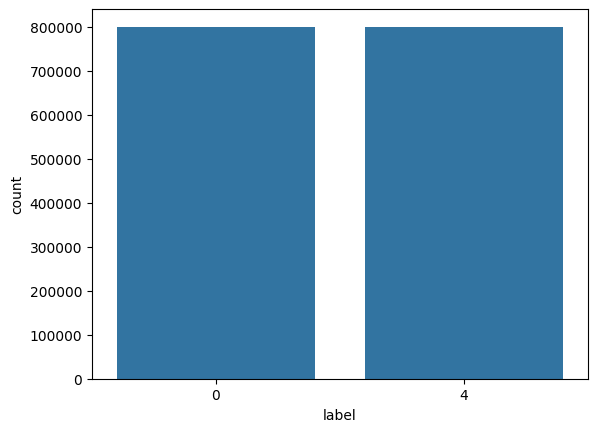

In [102]:
!pip install seaborn
import seaborn as sns
sns.countplot(x='label', data=data)

#### so the proportion between negative and positive sentiments are balance

# Data Preprocessing

In [103]:
# First of all, having two labels 0 and 4 are confusing, I will just subtitute the label into 0, and 1:

In [104]:
data['label'] = data['label'].replace(4,1)
print(data['label'].unique())

[0 1]


In [105]:
# Now, I will separate positive and negative tweets into two different variables
positive_tweets = data[data['label'] == 1]
negative_tweets = data[data['label'] == 0]
print(len(positive_tweets), len(negative_tweets))

800000 799999


## Part 1

in this data preprocessing, I will do some cleaning and data transformation as follows:
1. remove URLs
2. remove user mentiones (@username)
3. remove hastags
4. remove special characters and punctuations
5. convert them to lower case
6. remove stop words
7. removing numbers

## Part 2
Tokenization
A. Perform tokenization using nltk

## Part 3
Further text normalization
- Handle negations (such as 'no' , "never") since it might flip the sentiment of a sentence
- Correcting spelling error
- Handles emoji and emoticon **(no emoji and emoticon in this particular dataset)**
- Stemming or Lematization (reduce words to their root form e.g. running become run)


Final Transformation for modeling:
Text Vectorization (convert text into Numerical format so that ML model can understand) 
e.g. Bag of Words, TF-IDF (TfidfVectorizer), word embedding using pre-trained model such as Word2Vec or GloVe, Transformer Embedding (like BERT)



In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   label      1599999 non-null  int64 
 1   id         1599999 non-null  int64 
 2   timestamp  1599999 non-null  object
 3   no_query   1599999 non-null  object
 4   username   1599999 non-null  object
 5   tweet      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [107]:
def remove_url(text):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)

In [108]:
def remove_stopwords(text):
    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
    return " ".join([word for word in str(text).split() if word not in stopwordlist])


In [109]:
def remove_user_mentiones(text):
    return re.sub(r'((@[^\s]+))', ' ', text)

In [110]:
def remove_hastag(text):
    return re.sub(r'((#[^\s]+))', ' ', text)

In [111]:
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
def cleaning_punctuations(text):
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [112]:
def removing_numbers(text):
    return re.sub(r'(([1-9]))','',text)

In [113]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    """Convert Treebank POS tag to WordNet POS tag."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no clear mapping

def lemmatizer_with_pos(tokens):
    lm = nltk.WordNetLemmatizer()
    lemmatized_tokens = []
    tagged_tokens = nltk.pos_tag(tokens)  # Perform POS tagging
    for word, tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_tokens.append(lm.lemmatize(word, pos=wordnet_pos))
    return lemmatized_tokens # Return a list of lemmatized tokens for direct inspection

## Data Cleaning Part 1


In [114]:
# data['tweet'] = data['tweet'].apply(lambda text: remove_stopwords(text))
data['tweet'] = data['tweet'].apply(lambda text: remove_url(text))
data['tweet'] = data['tweet'].apply(lambda text: remove_user_mentiones(text))
data['tweet'] = data['tweet'].apply(lambda text: remove_hastag(text))
# data['tweet'] = data['tweet'].apply(lambda text: cleaning_punctuations(text))
data['tweet'] = data['tweet'].apply(lambda text: removing_numbers(text))
data['tweet'] = data['tweet'].str.lower()


In [115]:
data.shape

(1599999, 6)

## Part 2 : Tokenization

In [116]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['tweet'] = data['tweet'].apply(tokenizer.tokenize)

In [117]:
data.head(50)

,label,id,timestamp,no_query,username,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[is, upset, that, he, can, t, update, his, fac..."
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[i, dived, many, times, for, the, ball, manage..."
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[my, whole, body, feels, itchy, and, like, its..."
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[no, it, s, not, behaving, at, all, i, m, mad,..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,"[not, the, whole, crew]"
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,"[need, a, hug]"
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"[hey, long, time, no, see, yes, rains, a, bit,..."
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,"[nope, they, didn, t, have, it]"
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,"[que, me, muera]"
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,"[spring, break, in, plain, city, it, s, snowing]"


#### Stemming: 
- Might be preferred in applications where speed is crucial and a slight loss of accuracy is acceptable (e.g., in some information retrieval systems or when dealing with very large datasets).   
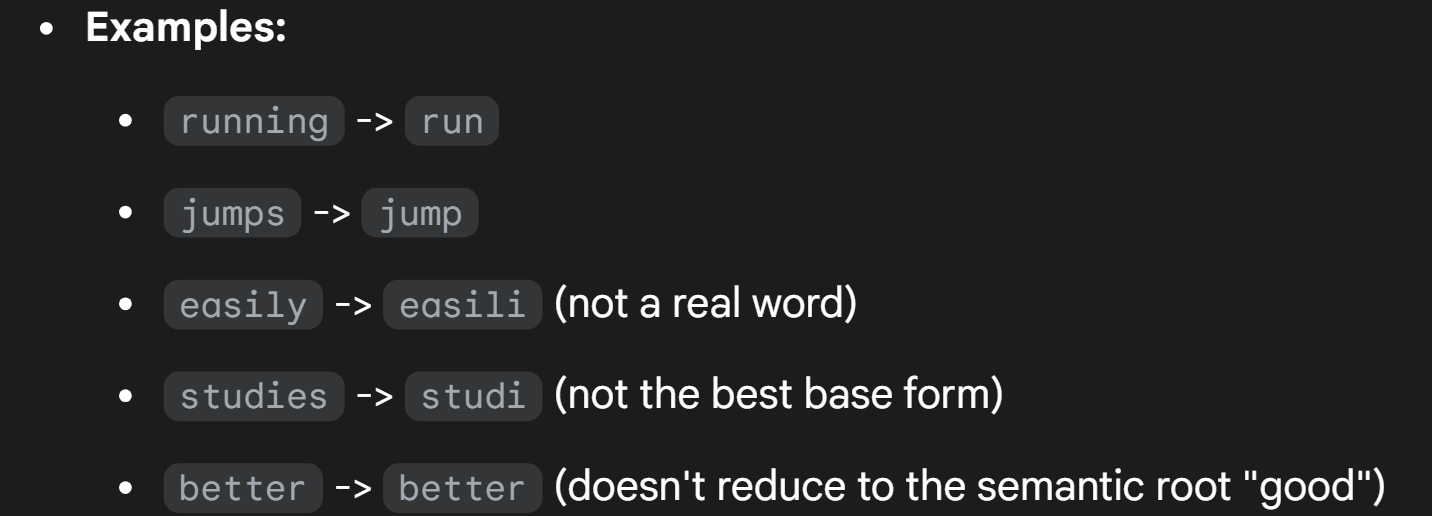

#### Lemmatization: 
- Process: Lemmatization is a more sophisticated process that uses a vocabulary (like WordNet) and morphological analysis to determine the base or dictionary form of a word, which is known as the lemma.

 
- Is generally preferred when the meaning of the word is important for downstream tasks, such as in chatbots, machine translation, text summarization, and sentiment analysis where understanding the context is key.

   



In [118]:
data.shape

(1599999, 6)

## Part 3: Further Text Transformation

In [119]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\HP-Miko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [120]:
# data['tweet'] = data['tweet'].apply(lambda x: lemmatizer_with_pos(x))

In [121]:
data.shape

(1599999, 6)

In [122]:
data2 = data[['label','tweet']].copy()

In [123]:
data2.head

<bound method NDFrame.head of          label                                              tweet
0            0  [is, upset, that, he, can, t, update, his, fac...
1            0  [i, dived, many, times, for, the, ball, manage...
2            0  [my, whole, body, feels, itchy, and, like, its...
3            0  [no, it, s, not, behaving, at, all, i, m, mad,...
4            0                            [not, the, whole, crew]
...        ...                                                ...
1599994      1  [just, woke, up, having, no, school, is, the, ...
1599995      1  [thewdb, com, very, cool, to, hear, old, walt,...
1599996      1  [are, you, ready, for, your, mojo, makeover, a...
1599997      1  [happy, th, birthday, to, my, boo, of, alll, t...
1599998      1                                            [happy]

[1599999 rows x 2 columns]>

In [124]:
#save the data into pickle file
data2.to_pickle('final cleaned data input without any embedding without punctuation without stop words without lemmatization.pkl')